# 0.Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 0.1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import pickle as pkl
if False:
    env = UnityEnvironment(file_name="./Banana.app", seed=42)
    # get the default brain
    brain_name = env.brain_names[0]
    brain      = env.brains[brain_name]

### 0.2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [2]:
if False:
    # reset the environment
    env_info = env.reset(train_mode=True)[brain_name]

    # number of agents in the environment
    print('Number of agents:', len(env_info.agents))

    # number of actions
    action_size = brain.vector_action_space_size
    print('Number of actions:', action_size)

    # examine the state space 
    state = env_info.vector_observations[0]
    print('States look like:', state)
    state_size = len(state)
    print('States have length:', state_size)

### 0.3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [3]:
do_sample = False
if do_sample:
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0                                          # initialize the score
    _ = -1
    while True:
        _ += 1
        action     = np.random.randint(action_size)    # select an action
        env_info   = env.step(action)[brain_name]      # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward     = env_info.rewards[0]               # get the reward
        done       = env_info.local_done[0]            # see if episode has finished
        score     += reward                            # update the score
        state      = next_state                        # roll over the state to next time step
        print(_, end=" ")
        if done:                                       # exit loop if episode finished
            break
    print("Score: {}".format(score))

When finished, you can close the environment.

# A)  It's My Turn!



Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

## A.1) just trying to create a state-value function

### A.1.1) helper functions

In [4]:
def get_init(nb_action_unique):
    """
    Create 3 dict with auto creation of values zeros 
    """
    from collections import defaultdict
    nb_actions = nb_action_unique
    zeros      = lambda: np.zeros(nb_actions)
    N          = defaultdict(zeros) # compte le nombre de passage sur l'action (N = nombre de passage)
    R          = defaultdict(zeros) # somme les gains par case (R = return)
    Q          = defaultdict(zeros) # Moyenne du gain par nombre de passage (Q = euh...)
    return N,R,Q

In [5]:
def print_info(i_episode,num_episodes, modulo=1000):
    import sys
    if i_episode % modulo == 0:
        print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
        sys.stdout.flush()

### A.1.2) helper functions : generate episode

In [6]:
def generate_episode(env, brain_name):
    """
    
    """
    episode  = []
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state    = env_info.vector_observations[0]            # get the current state
    score    = 0                                          # initialize the score
    _ = -1
    modulo_display = 10
    while True:
        _ +=1
        print_info(_, length_episode, modulo_display)
        action     = np.random.randint(action_size)    # select an action
        env_info   = env.step(action)[brain_name]      # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward     = env_info.rewards[0]               # get the reward
        done       = env_info.local_done[0]            # see if episode has finished
        score     += reward                            # update the score
        episode.append((state, action, reward))
        state      = next_state                        # roll over the state to next time step
        if done:                                        #exit loop if episode finished
            break
    return episode

### A.1.3) helper functions : create state-value function

In [7]:
def construct_q(env, brain_name, nb_action_unique, num_episodes, generate_episode, gamma=1.0):
    """
    Create a state-value function Q for a given environment and number of actions.
    """
    # initialize empty dictionaries of arrays
    import sys
    Nb_de_passage,Gain_total,Q_gain_moyen = get_init(nb_action_unique)
    # loop over episodes
    for i_episode in range(num_episodes):
        print_info(i_episode,num_episodes)# monitor progress
        list_triplet  = generate_episode(env, brain_name)
        rewards       = [triplet[2] for triplet in list_triplet] 
        nb_cartes     = len(rewards)
        discounts     = np.array([gamma**i for i in range(nb_cartes+1)])
        for i , (state, indice_action, reward) in enumerate(list_triplet):
            somme_des_gains_d_ici_a_la_fin        = sum(rewards[i:]*discounts[:-(1+i)])
            tuple_state = tuple(state)
            Nb_de_passage [tuple_state][indice_action] += 1
            Gain_total    [tuple_state][indice_action] += somme_des_gains_d_ici_a_la_fin # Gains entre 1 et -1
            esperated_win                               = Gain_total[tuple_state][indice_action]
            nb_of_passage                               = Nb_de_passage [tuple_state][indice_action]
            gain_moyen                                  = esperated_win / nb_of_passage
            Q_gain_moyen  [tuple_state][indice_action]  = gain_moyen
    """
    Q contains :
        each key = state, on 37 values
        each value = array of 4 values 
            \=> each value correspond to the average return for each of the 4 action
    """
    return Q_gain_moyen

### A.2) Code to test

In [8]:
if False: # so that we switch the cell and do a "Cell run all" 
    nb_action_unique = 4
    nb_episode       = 10
    Q = construct_q(env,brain_name,nb_action_unique,  nb_episode, generate_episode )

## B) Making the magic happend


## B.1) generate episode from the State-value function

In [9]:
def generate_episode_from_Q(env, Q, epsilon, nA=2):
    import sys
    # settings
    possible_actions = list(range(nA))
    episode   = []
    proba_min = epsilon/nA
    proba_max = 1-epsilon + proba_min
    # code
    print("env going to be reseted")
    state     = env.reset(train_mode=True)
    print("env going reseted")    
    _ = 0
    nb_error = 0
    while True:
        try:
            _ += 1
            print_info(_, 100, 10)
            tuple_state = tuple(state)
            # helping the best action to be selected, but still exploring
            probas                         = [proba_min] * nA
            best_action_so_far             = np.argmax(Q[tuple_state])
            probas[best_action_so_far]     = proba_max
            # selecting an action
            action                         = np.random.choice(possible_actions, p=probas)  
            # applying the selected action
            env_info   = env.step(action)[brain_name]      # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward     = env_info.rewards[0]               # get the reward
            done       = env_info.local_done[0]            # see if episode has finished

            # saving the result
            episode.append((state, action, reward))
            #going ahead
            state        = next_state
            if done:
                break
        except:
            print(_, tuple_state)
            nb_error+=1
            if nb_error>10:
                print(nb_error)
                break
    return episode        
        
    

## B.2) Update the State-value function -> learning ! 

In [10]:
def update_Q(episode, Q, alpha, gamma):
    """
    Update the state-value function Q with the given value 
    of the actions choosed at each given state.
    """
    # unzipping the data from the episode
    states, actions, rewards = zip(*episode)
    # applying gamma
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    
    for i, state in enumerate(states):
        tuple_state = tuple(state)
        # fetching last esperance :
        action_at_step_i           = actions[i]
        previous_expected_value    = Q[tuple_state][action_at_step_i] 
        # comparing with new episode : 
        new_expected_value         = sum(rewards[i:]*discounts[:-(1+i)])
        diff_in_expected_value     = new_expected_value - previous_expected_value
        # updating Q : 
        Q[tuple_state][action_at_step_i] = previous_expected_value + alpha*diff_in_expected_value

    return Q



In [11]:
def get_policy(Q):
    policy = dict((k,np.argmax(v)) for k, v in Q.items())    
    return policy

## B.3) Loop a vast amount of time between learning and updating 

In [12]:
def control(env, nb_of_possible_action, num_episodes, alpha, epsilon, gamma=1.0):
    """
    env : env
    nA : 
    """
    from collections import defaultdict
    import sys
    # initialize empty dictionary of arrays
    Q      = defaultdict(lambda: np.zeros(nb_of_possible_action))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        print(i_episode); sys.stdout.flush()
        print_info(i_episode, num_episodes, 10)
        ## TODO: complete the function
        print("generate_episode_from_Q")
        episode = generate_episode_from_Q(env, Q,  epsilon, nb_of_possible_action)
        print("update_Q")
        Q       = update_Q(episode, Q, alpha, gamma)
    return get_policy(Q), Q

## B.4) Test

In [13]:
do_training = True
if do_training:
    try:
        env.close()
    except:
        try:
            del env
        except:
            pass
    env = UnityEnvironment(file_name="./Banana.app", no_graphics=True, seed=42)
    brain_name = env.brain_names[0]
    brain      = env.brains[brain_name]
    policy, Q = control(env,4, 3000, 0.03, 0.5)    

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


1
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
3
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
4
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
5
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
6
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
7
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
8
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
9
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
10
Episode 10/3000.generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
11
generate_episode_from_Q
env going to be reseted
en

Episode 300/100.update_Q
172
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
173
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
174
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
175
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
176
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
177
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
178
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
179
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
180
Episode 180/3000.generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
181
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
182
gene

Episode 300/100.update_Q
257
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
258
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
259
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
260
Episode 260/3000.generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
261
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
262
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
263
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
264
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
265
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
266
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
267
gene

Episode 300/100.update_Q
342
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
343
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
344
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
345
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
346
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
347
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
348
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
349
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
350
Episode 350/3000.generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
351
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
352
gene

Episode 300/100.update_Q
427
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
428
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
429
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
430
Episode 430/3000.generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
431
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
432
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
433
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
434
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
435
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
436
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
437
gene

Episode 300/100.update_Q
512
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
513
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
514
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
515
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
516
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
517
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
518
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
519
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
520
Episode 520/3000.generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
521
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
522
gene

Episode 300/100.update_Q
597
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
598
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
599
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
600
Episode 600/3000.generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
601
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
602
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
603
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
604
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
605
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
606
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
607
gene

Episode 300/100.update_Q
682
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
683
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
684
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
685
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
686
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
687
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
688
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
689
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
690
Episode 690/3000.generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
691
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
692
gene

Episode 300/100.update_Q
767
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
768
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
769
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
770
Episode 770/3000.generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
771
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
772
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
773
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
774
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
775
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
776
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
777
gene

Episode 300/100.update_Q
852
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
853
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
854
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
855
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
856
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
857
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
858
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
859
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
860
Episode 860/3000.generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
861
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
862
gene

Episode 300/100.update_Q
937
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
938
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
939
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
940
Episode 940/3000.generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
941
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
942
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
943
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
944
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
945
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
946
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
947
gene

Episode 300/100.update_Q
1022
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1023
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1024
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1025
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1026
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1027
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1028
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1029
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1030
Episode 1030/3000.generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1031
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update

Episode 300/100.update_Q
1106
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1107
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1108
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1109
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1110
Episode 1110/3000.generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1111
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1112
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1113
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1114
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1115
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update

Episode 300/100.update_Q
1190
Episode 1190/3000.generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1191
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1192
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1193
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1194
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1195
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1196
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1197
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1198
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1199
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update

Episode 300/100.update_Q
1274
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1275
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1276
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1277
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1278
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1279
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1280
Episode 1280/3000.generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1281
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1282
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1283
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update

Episode 300/100.update_Q
1358
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1359
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1360
Episode 1360/3000.generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1361
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1362
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1363
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1364
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1365
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1366
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1367
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update

Episode 300/100.update_Q
1442
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1443
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1444
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1445
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1446
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1447
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1448
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1449
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1450
Episode 1450/3000.generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1451
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update

Episode 300/100.update_Q
1526
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1527
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1528
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1529
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1530
Episode 1530/3000.generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1531
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1532
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1533
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1534
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1535
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update

Episode 300/100.update_Q
1610
Episode 1610/3000.generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1611
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1612
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1613
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1614
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1615
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1616
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1617
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1618
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1619
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update

Episode 300/100.update_Q
1694
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1695
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1696
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1697
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1698
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1699
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1700
Episode 1700/3000.generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1701
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1702
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1703
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update

Episode 300/100.update_Q
1778
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1779
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1780
Episode 1780/3000.generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1781
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1782
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1783
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1784
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1785
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1786
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1787
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update

Episode 300/100.update_Q
1862
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1863
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1864
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1865
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1866
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1867
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1868
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1869
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1870
Episode 1870/3000.generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1871
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update

Episode 300/100.update_Q
1946
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1947
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1948
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1949
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1950
Episode 1950/3000.generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1951
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1952
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1953
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1954
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
1955
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update

Episode 300/100.update_Q
2030
Episode 2030/3000.generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2031
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2032
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2033
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2034
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2035
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2036
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2037
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2038
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2039
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update

Episode 300/100.update_Q
2114
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2115
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2116
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2117
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2118
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2119
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2120
Episode 2120/3000.generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2121
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2122
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2123
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update

Episode 300/100.update_Q
2198
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2199
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2200
Episode 2200/3000.generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2201
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2202
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2203
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2204
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2205
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2206
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2207
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update

Episode 300/100.update_Q
2282
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2283
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2284
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2285
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2286
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2287
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2288
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2289
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2290
Episode 2290/3000.generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2291
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update

Episode 300/100.update_Q
2366
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2367
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2368
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2369
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2370
Episode 2370/3000.generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2371
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2372
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2373
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2374
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2375
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update

Episode 300/100.update_Q
2450
Episode 2450/3000.generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2451
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2452
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2453
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2454
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2455
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2456
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2457
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2458
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2459
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update

Episode 300/100.update_Q
2534
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2535
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2536
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2537
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2538
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2539
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2540
Episode 2540/3000.generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2541
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2542
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2543
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update

Episode 300/100.update_Q
2618
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2619
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2620
Episode 2620/3000.generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2621
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2622
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2623
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2624
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2625
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2626
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2627
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update

Episode 300/100.update_Q
2702
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2703
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2704
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2705
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2706
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2707
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2708
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2709
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2710
Episode 2710/3000.generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2711
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update

Episode 300/100.update_Q
2786
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2787
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2788
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2789
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2790
Episode 2790/3000.generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2791
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2792
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2793
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2794
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2795
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update

Episode 300/100.update_Q
2870
Episode 2870/3000.generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2871
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2872
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2873
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2874
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2875
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2876
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2877
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2878
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2879
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update

Episode 300/100.update_Q
2954
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2955
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2956
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2957
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2958
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2959
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2960
Episode 2960/3000.generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2961
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2962
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update_Q
2963
generate_episode_from_Q
env going to be reseted
env going reseted
Episode 300/100.update

# B.5) save results

In [ ]:
do_save = True
if do_save:
    import pickle

    with open("policy.pkl", "wb") as f:
        pickle.dump(policy, f)

    _ = dict(Q)
    with open("Q.pkl", "wb") as f:
        pickle.dump(_, f)

# Warning : saving the result wasn't successfull as the keys were tuples, while pickle doesn't allow tuple to be wrote down. I couldn't really dump and load and make it work again ! 

## B.6) did we solve the problem ?

In [14]:
do_import = False
if do_import:
    import pickle
    with open("Q.pkl", "rb") as f:
        Q = pickle.load(f)

In [ ]:
if do_import:
    list_keys  = list(Q.keys())[1:]
    tuple_keys = [tuple(x) for x in list_keys]
    values     = [Q[x] for x in list_keys]

In [15]:
if do_import:
    type(tuple_keys[1][0])
    Q2 = dict(zip(tuple_keys, values))
    Q = Q2

In [16]:
total_reward = 0
r = []
for i in range(1):
    local_states, local_actions, local_reward = zip(*generate_episode_from_Q(env,Q,0.5, 4))
    won = sum(local_reward)
    total_reward += won
    r.append(total_reward)
    print("{i} - won {won}, total = {total_reward}".format(**locals()))

env going to be reseted
env going reseted
Episode 300/100.0 - won -3.0, total = -3.0


# Re-runing after failing to pickle

In [17]:
total_reward = 0
r = []
for i in range(100):
    local_states, local_actions, local_reward = zip(*generate_episode_from_Q(env,Q,0.5, 4))
    won = sum(local_reward)
    total_reward += won
    r.append(total_reward)
    print("{i} - won {won}, total = {total_reward}".format(**locals()))

env going to be reseted
env going reseted
Episode 300/100.0 - won -1.0, total = -1.0
env going to be reseted
env going reseted
Episode 300/100.1 - won 2.0, total = 1.0
env going to be reseted
env going reseted
Episode 300/100.2 - won 0.0, total = 1.0
env going to be reseted
env going reseted
Episode 300/100.3 - won -2.0, total = -1.0
env going to be reseted
env going reseted
Episode 300/100.4 - won -1.0, total = -2.0
env going to be reseted
env going reseted
Episode 300/100.5 - won -1.0, total = -3.0
env going to be reseted
env going reseted
Episode 300/100.6 - won 5.0, total = 2.0
env going to be reseted
env going reseted
Episode 300/100.7 - won -2.0, total = 0.0
env going to be reseted
env going reseted
Episode 300/100.8 - won 0.0, total = 0.0
env going to be reseted
env going reseted
Episode 300/100.9 - won -1.0, total = -1.0
env going to be reseted
env going reseted
Episode 300/100.10 - won -2.0, total = -3.0
env going to be reseted
env going reseted
Episode 300/100.11 - won 0.0, t

In [19]:
total_reward

22.0

# Picklising only the rewards

In [2]:
import pickle as pkl

In [ ]:
with open ("./liste_de_100_resultats.pkl", "wb") as f:
    pkl.dump(r, f)

# Generating a plot 

In [3]:
with open ("./liste_de_100_resultats.pkl", "rb") as f:
    r = pkl.load(f)

In [5]:
import pandas as pd
import numpy as np

In [7]:
df = pd.DataFrame(r)

In [19]:
first_win = np.argmax(np.array(r)>13)

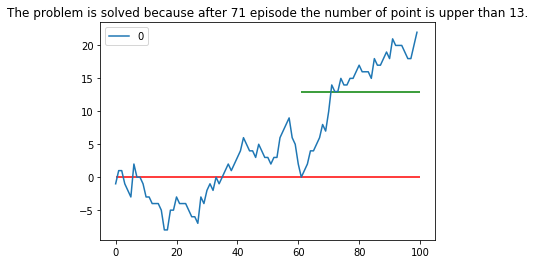

In [47]:
%matplotlib inline
title = "The problem is solved because after {first_win} episode the number of point is upper than 13.".format(**locals())
ax = df.plot.line(title=title)
ax.hlines(y=13, xmin=first_win-10, xmax=100, color="green")
ax.hlines(y=0 , xmin=0, xmax=100, color="red")